In [2]:
import scipy
import pandas as pd
from ogb.utils import smiles2graph
from torch_geometric.data import DataLoader
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)
from torch.optim.lr_scheduler import LinearLR, ConstantLR, ExponentialLR, SequentialLR
from torch_geometric.data import Data
import torch
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm import tqdm
import os
from utils import *
from dataProcessing import *
logger = get_logger()
conformer_flag =False
logger.info(device)

/home/s/sainathreddyb/.conda/envs/gpuenv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


2023-01-13 17:48:53,757 - utils - INFO - This is a test log message
2023-01-13 17:48:53,759 - utils - INFO - cpu


In [3]:
X_train = pd.read_csv('train.csv')
X_val = pd.read_csv('val.csv')
X_test = pd.read_csv('test.csv')

In [4]:
#loading fingerprint and conformer data
rf_dict = np.load('rf.npy',allow_pickle=True).item()
cf_dict = np.load('cf.npy',allow_pickle=True).item()



In [5]:
data_scaler = DataScaler(categorical_column='measurement_type', label='measurement_value',scale_by_group=False)
X_train = data_scaler.fit_transform(X_train)
X_val = data_scaler.transform(X_val)
X_test = data_scaler.transform(X_test)


In [6]:

class convert_df_fea(DataPreprocessor):
    def __init__(self, rf_dict,X_train):
        super().__init__(X_train)
        self.rf_dict = rf_dict
        
    def transform(self, X):
        X = super().transform(X)
        X['mf'] = X['SMILES'].map(self.rf_dict)      
        return X

data_preprocessor = convert_df_fea(rf_dict,X_train)
X_train = data_preprocessor.transform(X_train)
X_val = data_preprocessor.transform(X_val)
X_test = data_preprocessor.transform(X_test)

### converting smile --> torch graph Data object

In [7]:
def smile_to_graph(df):
    pyg_graph_list=[]

    for i in range(len(df)):
        sample = df.iloc[i]
        graph=smiles2graph(sample.SMILES)
        
        
        g = Data()
        g.num_nodes = graph['num_nodes']
        g.edge_index = torch.from_numpy(graph['edge_index'])

        del graph['num_nodes']
        del graph['edge_index']

        if graph['edge_feat'] is not None:
            g.edge_attr = torch.from_numpy(graph['edge_feat'])
            del graph['edge_feat']

        if graph['node_feat'] is not None:
            if conformer_flag:
                g.x = torch.from_numpy(np.concatenate((graph['node_feat'],cf_dict[sample.SMILES].astype(int)),axis=-1))
            else:
                g.x = torch.from_numpy(graph['node_feat'])
            del graph['node_feat']

        g.y = torch.from_numpy(np.array(sample.measurement_value)).to(torch.float32)
        
        
        
        g['cat']=torch.from_numpy(np.concatenate((sample.measurement_type ,sample.Kinase_name,rf_dict[sample.SMILES]))).to(torch.float32)
        
        
        pyg_graph_list.append(g)
        
    return pyg_graph_list

    

In [8]:
#sanity
smile_to_graph(X_train[:3])

[Data(num_nodes=31, edge_index=[2, 66], edge_attr=[66, 3], x=[31, 9], y=0.13477537035942078, cat=[4690]),
 Data(num_nodes=31, edge_index=[2, 66], edge_attr=[66, 3], x=[31, 9], y=0.3410981595516205, cat=[4690]),
 Data(num_nodes=26, edge_index=[2, 58], edge_attr=[58, 3], x=[26, 9], y=0.7088186144828796, cat=[4690])]

## CoATGIN model

In [12]:
from torch_geometric.loader import DataLoader
from tqdm import tqdm

import numpy as np
import torch as pt
import torch.nn as nn
import torch.nn.parameter as nnp
import torch.nn.functional as nnf

from torch_scatter import scatter
from torch_geometric.utils import degree
from torch_geometric.nn import MessagePassing
from ogb.graphproppred.mol_encoder import AtomEncoder, BondEncoder


allowable_features = {
    'possible_atomic_num_list' : list(range(1, 119)) + ['misc'],
    'possible_chirality_list' : [
        'CHI_UNSPECIFIED',
        'CHI_TETRAHEDRAL_CW',
        'CHI_TETRAHEDRAL_CCW',
        'CHI_OTHER',
        'misc'
    ],
    'possible_degree_list' : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 'misc'],
    'possible_formal_charge_list' : [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 'misc'],
    'possible_numH_list' : [0, 1, 2, 3, 4, 5, 6, 7, 8, 'misc'],
    'possible_number_radical_e_list': [0, 1, 2, 3, 4, 'misc'],
    'possible_hybridization_list' : [
        'SP', 'SP2', 'SP3', 'SP3D', 'SP3D2', 'misc'
        ],
    'possible_is_aromatic_list': [False, True],
    'possible_is_in_ring_list': [False, True],
    'possible_bond_type_list' : [
        'SINGLE',
        'DOUBLE',
        'TRIPLE',
        'AROMATIC',
        'misc'
    ],
    'possible_bond_stereo_list': [
        'STEREONONE',
        'STEREOZ',
        'STEREOE',
        'STEREOCIS',
        'STEREOTRANS',
        'STEREOANY',
    ], 
    'possible_is_conjugated_list': [False, True],
}
import torch
from ogb.utils.features import get_atom_feature_dims, get_bond_feature_dims 

full_atom_feature_dims = list(map(len, [
        allowable_features['possible_atomic_num_list'],
        allowable_features['possible_chirality_list'],
        allowable_features['possible_degree_list'],
        allowable_features['possible_formal_charge_list'],
        allowable_features['possible_numH_list'],
        allowable_features['possible_number_radical_e_list'],
        allowable_features['possible_hybridization_list'],
        allowable_features['possible_is_aromatic_list'],
        allowable_features['possible_is_in_ring_list']
        ]))

class AtomEncoder(torch.nn.Module):

    def __init__(self, emb_dim):
        super(AtomEncoder, self).__init__()
        
        self.atom_embedding_list = torch.nn.ModuleList()

        for i, dim in enumerate(full_atom_feature_dims):
            if conformer_flag:
                emb = torch.nn.Embedding(dim, emb_dim-3)
            else:
                emb = torch.nn.Embedding(dim, emb_dim)
            torch.nn.init.xavier_uniform_(emb.weight.data)
            self.atom_embedding_list.append(emb)

    def forward(self, x):
        x_embedding = 0
        for i in range(len(full_atom_feature_dims)):
            x_embedding += self.atom_embedding_list[i](x[:,i])
             
        # x_embedding = torch.cat((x_embedding, x[:,i+1:]), dim=1)
                
        return x_embedding
    
MAX_DEGREE = 4


# DeepNet: https://arxiv.org/abs/2203.00555v1
class ScaleLayer(nn.Module):
    def __init__(self, width, scale_init):
        super().__init__()
        self.scale = nnp.Parameter(pt.zeros(width) + np.log(scale_init))

    def forward(self, x):
        return pt.exp(self.scale) * x

# Graphormer: https://arxiv.org/abs/2106.05234v5
class ScaleDegreeLayer(nn.Module):
    def __init__(self, width, scale_init):
        super().__init__()
        self.scale = nnp.Parameter(pt.zeros(MAX_DEGREE, width) + np.log(scale_init))

    def forward(self, x, deg):
        return pt.exp(self.scale)[deg] * x

# GLU: https://arxiv.org/abs/1612.08083v3
class GatedLinearBlock(nn.Module):
    def __init__(self, width, num_head, scale_act, dropout=0.1, block_name=None):
        super().__init__()

        self.pre   = nn.Sequential(nn.Conv1d(width, width, 1),
                         nn.GroupNorm(num_head, width, affine=False))
        self.gate  = nn.Sequential(nn.Conv1d(width, width*scale_act, 1, bias=False, groups=num_head),
                         nn.ReLU(), nn.Dropout(dropout))
        self.value = nn.Conv1d(width, width*scale_act, 1, bias=False, groups=num_head)
        self.post  = nn.Conv1d(width*scale_act, width, 1)
        if block_name is not None:
            print('##params[%s]:' % block_name, np.sum([np.prod(p.shape) for p in self.parameters()]))

    def forward(self, x):
        xx = self.pre(x.unsqueeze(-1))
        xx = self.gate(xx) * self.value(xx)
        xx = self.post(xx).squeeze(-1)
        return xx

class GatedLinearBlock2(nn.Module):
    def __init__(self, width, num_head, scale_act, dropout=0.1):
        super().__init__()

        self.gate  = nn.Sequential(nn.GroupNorm(num_head, width, affine=False),
                         nn.Conv1d(width, width*scale_act, 1, bias=False, groups=num_head),
                         nn.ReLU(), nn.Dropout(dropout))
        self.value = nn.Sequential(nn.GroupNorm(num_head, width, affine=False),
                         nn.Conv1d(width, width*scale_act, 1, bias=False, groups=num_head))
        self.post  = nn.Conv1d(width*scale_act, width, 1)

    def forward(self, xg, xv):
        xx = self.gate(xg.unsqueeze(-1)) * self.value(xv.unsqueeze(-1))
        xx = self.post(xx).squeeze(-1)
        return xx


# VoVNet: https://arxiv.org/abs/1904.09730v1
class ConvMessage(MessagePassing):
    def __init__(self, width, width_head, width_scale, hop, kernel, scale_init=0.1):
        super().__init__(aggr="add")
        self.width = width
        self.hop = hop

        self.bond_encoder = nn.ModuleList()
        self.pre = nn.ModuleList()
        self.msg = nn.ModuleList()
        self.scale = nn.ModuleList()
        for _ in range(hop*kernel):
            self.bond_encoder.append(BondEncoder(emb_dim=width))
            self.pre.append(nn.Linear(width, width, bias=False))
            self.msg.append(GatedLinearBlock2(width, width_head, width_scale))
            self.scale.append(ScaleDegreeLayer(width, scale_init))
        print('##params[conv]:', np.sum([np.prod(p.shape) for p in self.parameters()]))

    def forward(self, x, node_degree, edge_index, edge_attr):
        for layer in range(len(self.msg)):
            if layer == 0:
                x_raw, x_out = x, 0
            elif layer % self.hop == 0:
                x_raw, x_out = x + x_out, 0

            x_raw = self.propagate(edge_index, x=self.pre[layer](x_raw), edge_attr=edge_attr, layer=layer)
            x_out = x_out + self.scale[layer](x_raw, node_degree)
        return x_out

    def message(self, x_i, x_j, edge_attr, layer):
        bond = self.bond_encoder[layer](edge_attr)
        msg = self.msg[layer](x_i + bond, x_j + bond)
        return msg
        
    def update(self, aggr_out):
        return aggr_out

# GIN-virtual: https://arxiv.org/abs/2103.09430
class VirtMessage(nn.Module):
    def __init__(self, width, width_head, width_scale, scale_init=0.01):
        super().__init__()
        self.width = width

        self.msg = GatedLinearBlock(width, width_head, width_scale)
        self.scale = ScaleLayer(width, scale_init)
        print('##params[virt]:', np.sum([np.prod(p.shape) for p in self.parameters()]))

    def forward(self, x, x_res, batch, batch_size):
        xx = x_res = scatter(x, batch, dim=0, dim_size=batch_size, reduce='sum') + x_res
        xx = self.scale(self.msg(xx))[batch]
        return xx, x_res

# CosFormer: https://openreview.net/pdf?id=Bl8CQrx2Up4
class AttMessage(nn.Module):
    def __init__(self, width, width_head, width_scale, scale_init=0.01):
        super().__init__()
        self.width = width
        self.width_head = width_head

        num_grp = width // width_head
        self.pre  = nn.Sequential(nn.Conv1d(width, width, 1),
                         nn.GroupNorm(num_grp, width, affine=False))
        self.msgq = nn.Conv1d(width, width*width_scale, 1, bias=False, groups=num_grp)
        self.msgk = nn.Conv1d(width, width*width_scale, 1, bias=False, groups=num_grp)
        self.msgv = nn.Conv1d(width, width*width_scale, 1, bias=False, groups=num_grp)
        self.post = nn.Conv1d(width*width_scale, width, 1)
        self.scale = ScaleLayer(width, scale_init)
        print('##params[att]:', np.sum([np.prod(p.shape) for p in self.parameters()]))

    def forward(self, x, x_res, batch, batch_size):
        xv = self.pre(x.unsqueeze(-1))

        shape = [len(x), -1, self.width_head]
        xq = pt.exp(self.msgq(xv) / np.sqrt(self.width_head)).reshape(shape)
        xk = pt.exp(self.msgk(xv) / np.sqrt(self.width_head)).reshape(shape)
        xv = self.msgv(xv).reshape(shape)

        xv = pt.einsum('bnh,bnv->bnhv', xk, xv)
        xv = x_res = scatter(xv, batch, dim=0, dim_size=batch_size, reduce='sum') + x_res
        xk = scatter(xk, batch, dim=0, dim_size=batch_size, reduce='sum')[batch]
        xq = xq / pt.einsum('bnh,bnh->bn', xq, xk)[:, :, None]  # norm
        xv = pt.einsum('bnh,bnhv->bnv', xq, xv[batch]).reshape(len(x), -1, 1)

        xv = self.scale(self.post(xv).squeeze(-1))
        return xv, x_res


# GIN: https://openreview.net/forum?id=ryGs6iA5Km
class CoAtGIN(pt.nn.Module):
    def __init__(self, num_layers, emb_dim, conv_hop, conv_kernel, use_virt=True, use_att=True, JK=None, gnn_type=None):
        super().__init__()
        self.num_layers = num_layers

        self.atom_encoder = AtomEncoder(emb_dim)
        self.bond_encoder = BondEncoder(emb_dim)
        self.scale = ScaleDegreeLayer(emb_dim, 0.1)

        self.conv = pt.nn.ModuleList()
        self.virt = pt.nn.ModuleList()
        self.att = pt.nn.ModuleList()
        self.main = pt.nn.ModuleList()
        for layer in range(num_layers):
            self.conv.append(ConvMessage(emb_dim, 16, 1, conv_hop, conv_kernel))
            self.virt.append(VirtMessage(emb_dim, 16, 2) if use_virt else None)
            self.att.append(AttMessage(emb_dim, 16, 2) if use_att else None)
            self.main.append(GatedLinearBlock(emb_dim, 16, 3))  # debug

    def forward(self, batched_data):
        x, edge_index, edge_attr, batch = batched_data.x, batched_data.edge_index, batched_data.edge_attr, batched_data.batch
        batch_size = len(batched_data.ptr)-1
        node_degree = degree(edge_index[1], len(x)).long() - 1
        node_degree.clamp_(0, MAX_DEGREE - 1)

        h_in = self.bond_encoder(edge_attr)
        h_in = scatter(h_in, edge_index[1], dim=0, dim_size=len(x), reduce='sum')
        h_in = self.scale(h_in, node_degree)
        h_in, h_att, h_virt = self.atom_encoder(x) + h_in, 0, 0
        for layer in range(self.num_layers):
            h_out = h_in + self.conv[layer](h_in, node_degree, edge_index, edge_attr)
            if self.virt[layer] is not None:
                h_tmp, h_virt = self.virt[layer](h_in, h_virt, batch, batch_size)
                h_out, h_tmp = h_out + h_tmp, None
            if self.att[layer] is not None:
                h_tmp, h_att = self.att[layer](h_in, h_att, batch, batch_size)
                h_out, h_tmp = h_out + h_tmp, None
            h_out = h_in = self.main[layer](h_out)

        return h_out

In [13]:
import torch
from torch_geometric.nn import MessagePassing
from torch_geometric.nn import global_add_pool, global_mean_pool, global_max_pool, GlobalAttention, Set2Set
import torch.nn.functional as F
from torch_geometric.nn.inits import uniform

from torch_scatter import scatter_mean

class GNN(torch.nn.Module):

    def __init__(self, num_tasks = 1, num_layers = 5, emb_dim = 300, 
                    gnn_type = 'gin', virtual_node = 2, conv_hop = 2, conv_kernel = 2, residual = False,
                    drop_ratio = 0, JK = "last", graph_pooling = "sum"):
        '''
            num_tasks (int): number of labels to be predicted
            virtual_node (bool): whether to add virtual node or not
        '''
        super(GNN, self).__init__()

        self.num_layers = num_layers
        self.drop_ratio = drop_ratio
        self.JK = JK
        self.emb_dim = emb_dim
        self.num_tasks = num_tasks
        self.graph_pooling = graph_pooling

        if self.num_layers < 2:
            raise ValueError("Number of GNN layers must be greater than 1.")

        ### GNN to generate node embeddings
            
        self.gnn_node = CoAtGIN(num_layers, emb_dim, conv_hop, conv_kernel, JK=JK, gnn_type=gnn_type, use_virt=True, use_att=True)


        ### Pooling function to generate whole-graph embeddings
        if self.graph_pooling == "sum":
            self.pool = global_add_pool
        elif self.graph_pooling == "mean":
            self.pool = global_mean_pool
        elif self.graph_pooling == "max":
            self.pool = global_max_pool
        elif self.graph_pooling == "attention":
            self.pool = GlobalAttention(gate_nn = torch.nn.Sequential(torch.nn.Linear(emb_dim, emb_dim), torch.nn.BatchNorm1d(emb_dim), torch.nn.ReLU(), torch.nn.Linear(emb_dim, 1)))
        elif self.graph_pooling == "set2set":
            self.pool = Set2Set(emb_dim, processing_steps = 2)
        else:
            raise ValueError("Invalid graph pooling type.")

        self.norm = torch.nn.GroupNorm(1, self.emb_dim, affine=False)
        self.relu = nn.ReLU()
        
        self.cat_fea_size = 4690
        
        if graph_pooling == "set2set":
            self.head1 = torch.nn.Linear(self.emb_dim*2+self.cat_fea_size, 32)
            self.head2 = torch.nn.Linear(32, self.num_tasks)
        else:
            self.head1 = torch.nn.Linear(self.emb_dim+self.cat_fea_size, 32)
            self.head2 = torch.nn.Linear(32, self.num_tasks)

    def forward(self, batched_data):
        h = self.gnn_node(batched_data)
        h = self.pool(h, batched_data.batch)
        h = self.norm(h)    
        # print(h.shape,batched_data.cat.reshape(-1,6))
        h = self.head1(torch.cat((h,batched_data.cat.reshape(-1,self.cat_fea_size)),dim=-1))
        h = self.relu(h)
        h = self.head2(h)      
        if not self.training: h.clamp_(0, 1).squeeze()
        
        return h.squeeze()



In [14]:
shared_params = {
    'num_layers': 4,
    'emb_dim': 253+3,
    'drop_ratio': 0,
    'graph_pooling': 'sum'
}


model = GNN(gnn_type='gin', virtual_node=5, conv_hop=3, conv_kernel=2, **shared_params).to(device)

##params[conv]: 863232
##params[virt]: 213760
##params[att]: 221952
##params[conv]: 863232
##params[virt]: 213760
##params[att]: 221952
##params[conv]: 863232
##params[virt]: 213760
##params[att]: 221952
##params[conv]: 863232
##params[virt]: 213760
##params[att]: 221952


### train and eval pipeline

In [15]:
def eval(model, loader):
    model.eval()
    y_true = []
    y_pred = []

    for step, batch in enumerate(tqdm(loader, desc="Iteration")):
        batch = batch.to(device)

        with torch.no_grad():
            pred = model(batch).view(-1,)

        y_true.append(batch.y.view(pred.shape).detach().cpu())
        y_pred.append(pred.detach().cpu())

    y_true = torch.cat(y_true, dim = 0)
    y_pred = torch.cat(y_pred, dim = 0)

    return torch.abs(y_pred - y_true).mean().item()

def train(model, loader, optimizer):
    model.train()
    loss_accum = 0

    for step, batch in enumerate(tqdm(loader, desc="Iteration")):
        batch = batch.to(device)

        pred = model(batch).view(-1,)
        optimizer.zero_grad()
        loss = reg_criterion(pred, batch.y)
        loss.backward()
        optimizer.step()

        loss_accum += loss.detach().cpu().item()

    return loss_accum / (step + 1)

In [25]:

learn_rate, weight_decay = 3e-3, 2e-2
warmups, epochs ,batch_size= 20, 12 ,20

optimizer = torch.optim.Adam(params=model.parameters(), lr=learn_rate)
sched0 = LinearLR(optimizer, 1e-4, 1.0)
sched1 = ConstantLR(optimizer, 1.0)
sched2 = ExponentialLR(optimizer, (1e-5/learn_rate)**(1/epochs))
sched = SequentialLR(optimizer, [sched0, sched1, sched2], [warmups//5, warmups])

In [26]:
num_workers = 4
train_loader =  DataLoader(smile_to_graph(X_train), batch_size=batch_size,shuffle=True,num_workers=num_workers)
valid_loader =  DataLoader(smile_to_graph(X_val), batch_size=batch_size, shuffle=False, num_workers = num_workers)


/home/s/sainathreddyb/.conda/envs/gpuenv/lib/python3.8/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [25]:
best_valid_mae = 9999
checkpoint_dir = 'checkpoints1'
reg_criterion = torch.nn.L1Loss()

for epoch in range(warmups+epochs+1):
    logger.info("=====Epoch {}".format(epoch))
    print('Training...')
    train_mae = train(model, train_loader, optimizer)

    print('Evaluating...')
    valid_mae = eval(model, valid_loader)

    logger.info('#summary: %.4f %.4f %.2e' % (train_mae, valid_mae, sched.get_last_lr()[0]))

    if valid_mae < best_valid_mae:
        best_valid_mae = valid_mae
        if checkpoint_dir != '':
            print('Saving checkpoint...')
            checkpoint = {'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'best_val_mae': best_valid_mae}
            torch.save(checkpoint, os.path.join(checkpoint_dir, 'checkpoint.pt'))
    sched.step()

=====Epoch 0
Training...


Iteration: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Evaluating...


Iteration: 100%|██████████| 5/5 [00:00<00:00,  9.61it/s]
2023-01-11 21:59:54,929 - utils - INFO - #summary: 0.2372 0.1863 3.00e-07


Saving checkpoint...


In [24]:
checkpoint_dir = 'checkpoints1'
checkpoint = torch.load(os.path.join(checkpoint_dir, 'checkpoint.pt'), map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [52]:
def get_preds(loader,df):
    model.eval()
    y_true = []
    y_pred = []

    for step, batch in enumerate(tqdm(loader, desc="Iteration")):
        batch = batch.to(device)

        with torch.no_grad():
            pred = model(batch).view(-1,)

        y_true.append(batch.y.view(pred.shape).detach().cpu())
        y_pred.append(pred.detach().cpu())

    y_true = torch.cat(y_true, dim = 0)
    y_pred = torch.cat(y_pred, dim = 0)
    print("mae: ",np.mean(abs(y_true.numpy() - y_pred.numpy())))
    df['preds'] = y_pred.numpy()
    return df

In [51]:
test_loader =  DataLoader(smile_to_graph(X_test), batch_size=batch_size, shuffle=False, num_workers = num_workers)

/home/s/sainathreddyb/.conda/envs/gpuenv/lib/python3.8/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [54]:
X_test = get_preds(test_loader,X_test)

Iteration:   0%|          | 0/54 [00:00<?, ?it/s]/home/s/sainathreddyb/.conda/envs/gpuenv/lib/python3.8/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Iteration: 100%|██████████| 54/54 [00:42<00:00,  1.27it/s]

mae:  0.07407406


In [55]:
X_val = get_preds(valid_loader,X_val)

Iteration:   0%|          | 0/54 [00:00<?, ?it/s]/home/s/sainathreddyb/.conda/envs/gpuenv/lib/python3.8/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Iteration: 100%|██████████| 54/54 [00:43<00:00,  1.23it/s]

mae:  0.07892809


In [56]:
testit=pd.concat((X_test,X_val))
testit = data_scaler.inverse_transform(testit,'preds')
testit = data_scaler.inverse_transform(testit,'measurement_value')
testit = data_preprocessor.reverse_transform(testit)

In [57]:
get_accuracy_mae(testit)

unscaled mae: 0.45976470014390697
Accuracy of pKi :  0.7346938775510204
Accuracy of pIC50 :  0.7864992150706437


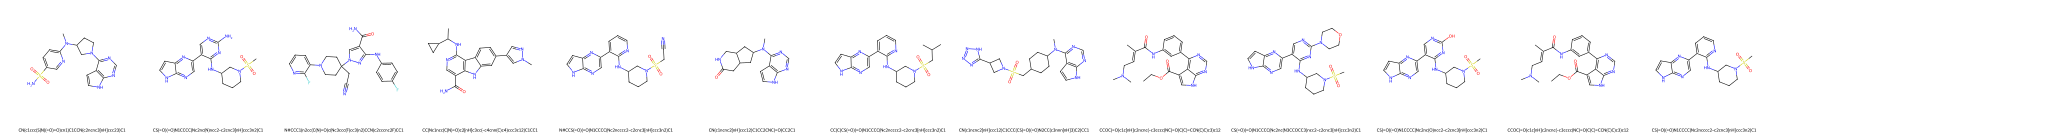

In [67]:


import matplotlib.pyplot as plt
from rdkit.Chem import Draw
from rdkit import Chem
# generate a list of "smile" molecules
smiles = testit[testit['abs']>2].SMILES.values
molecules = [Chem.MolFromSmiles(smile) for smile in smiles]

Draw.MolsToGridImage(molecules, molsPerRow=15, useSVG=True,subImgSize=(500, 500), legends=list(smiles))

####  most of the mispredictions have sulfonyl group (S(N)(=O)=O)

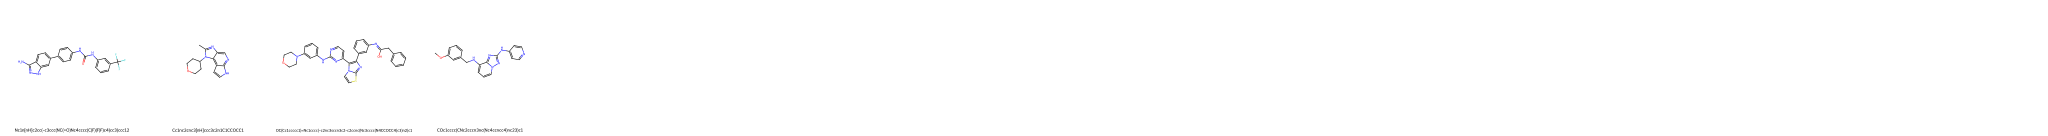

In [68]:
import matplotlib.pyplot as plt
from rdkit.Chem import Draw
from rdkit import Chem
# generate a list of "smile" molecules
smiles = testit[testit['abs']<0.001].SMILES.values
molecules = [Chem.MolFromSmiles(smile) for smile in smiles]

Draw.MolsToGridImage(molecules, molsPerRow=15, useSVG=True,subImgSize=(500, 500), legends=list(smiles))